# 2. Creating and simulating a simple arm model

## 2.1. Objectives

**Purpose**

The purpose of this tutorial is to introduce you to the creation of musculoskeletal models using [OpenSim](https://opensim.stanford.edu/) [[1]](https://doi.org/10.1109/TBME.2007.901024). In this tutorial you will:

*   Create a simple arm model.
*   Use the model to do a "forward simulation".
*   Plot information obtained from the simulation.

**Format**

In this tutorial, you will create an arm model. The model is very simple and consists of two bones (humerus and radius), and a muscle to bend the arm (biceps).

The first step of this tutorial will be to setup the environment (See ***Tutorial 1: Introduction to OpenSim in Colab***), and then you will programmatically create the model by defining the necessary bodies, muscles, and joints. Finally, you will perform Forward Kinematics [[2]](https://mitpress.mit.edu/9780262044202/biomechanics-of-movement/) on the model to obtain kinematic data.

## 2.2. Setup Conda and OpenSim

First, set up the environment by executing the following cell (See [Tutorial 1: Introduction to OpenSim in Colab](https://drive.google.com/file/d/1P_2IRJFzdodS1-ce4BsOsC9d8xWXCqXS/view?usp=sharing)).

Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, let's install the OpenSim conda package.

## 2.3. Create the model

Now it's time to create the model. First, you are going to import OpenSim and create an empty model named "bicep_curl".

In [20]:
import opensim as osim

# Create empty model and assign the name "bicep_curl" to it.
arm = osim.Model()
arm.setName("bicep_curl")

Let's create two bodies (the bones) using the `Body` class constructor function ([documentation](https://simtk.org/api_docs/opensim/api_docs/classOpenSim_1_1Body.html#ab1d061783d6e0b093e0794c19326e7c0)). This function takes 4 inputs:
  * **name**: use "humerus" and "radius" for the names of the two bodies
  * **mass**: set a mass of 1 $kg$ for both bodies
  * **center of mass location**: set the location to be the body's origin (i.e., $(0,0,0)$) in both bodies (`osim.Vec3(0)`)
  * **inertia**: use an inertia matrix with moments of inertia of 0.1, 0.5 and 0.1 $kg \cdot m^2$, in the x, y and z directions, respectively, and with products of inertia of 0 (`osim.Inertia(0.1, 0.5, 0.1)`)

In [21]:
# Define humerus.
humerus = osim.Body("humerus",
                    1.0,
                    osim.Vec3(0),
                    osim.Inertia(0.1, 0.5, 0.1))

# Define radius.
radius = osim.Body("radius",
                   1.0,
                   osim.Vec3(0),
                   osim.Inertia(0.1, 0.5, 0.1))

The model needs pin joints, and we'll use the `PinJoint` class constructor function (which uses the same input as `Joint`, [documentation](https://simtk.org/api_docs/opensim/api_docs/classOpenSim_1_1Joint.html#a31854c22f626c982ad67fcff12a94961)) to create two pin joints. The first pin joint corresponds with the shoulder, and connects the top of the humerus with the ground (the humerus is the root of the model). The second pin joint corresponds with the elbow and connects the bottom of the humerus with the top of the radius. Assume each body is 1 $m$ long.

In [22]:
# Shoulder pin joint from the ground to the humerus, so it is fixed and don't fall.
shoulder = osim.PinJoint("shoulder",
                         arm.getGround(), # PhysicalFrame
                         osim.Vec3(0),
                         osim.Vec3(0),
                         humerus, # PhysicalFrame
                         osim.Vec3(0, 0.5, 0), # attach the joint 0.5 m up from the humerus origin
                         osim.Vec3(0))

# Elbow pin joint from the humerus to the radius.
elbow = osim.PinJoint("elbow",
                      humerus, # PhysicalFrame
                      osim.Vec3(0, -0.5, 0), # attach the joint 0.5 m down from the humerus origin
                      osim.Vec3(0),
                      radius, # PhysicalFrame
                      osim.Vec3(0, 0.5, 0), # attach the joint 0.5 m up from the radius origin
                      osim.Vec3(0))

In order to flex the elbow, now you will add a muscle representing the biceps to the model. This muscle is an actuator that can be actively controlled to generate force. 

The muscle is created as a configurable muscle using the `Millard2012EquilibriumMuscle` class [[3]](https://doi.org/10.1115/1.4023390), and has a maximum isometric force of 100 $N$, optimal fiber length of 0.6 $m$, tendon slack length of 0.55 $m$, and a pennation angle of 0.0 $rad$. Then, two path points are defined with muscle's origin point in the humerus and insertion point in the radius.


In [23]:
# Create and set the parameters for the biceps muscle
biceps = osim.Millard2012EquilibriumMuscle("biceps",  # Muscle name
                                           100.0,  # Max isometric force
                                           0.6,  # Optimal fiber length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle

# Add path points to the humerus and radius. The allows the muscle to generate
# forces on these two bodies.
biceps.addNewPathPoint("origin",
                       humerus,
                       osim.Vec3(0, 0.3, 0))
biceps.addNewPathPoint("insertion",
                       radius,
                       osim.Vec3(0, 0.2, 0))

In order to excite the muscle (activate the actuator), the model needs a controller. In the following cell you will create a prescribed controller, add the biceps as an actuator to the controller, and specify the excitation of the muscle. In this example, the excitation is time-varying and defined by a step function ([documentation](https://simtk.org/api_docs/opensim/api_docs/classOpenSim_1_1StepFunction.html#afdce40906fc61bc7dbcfa026d1f0ad8b)).


In [24]:
# Create a controller, add the actuator (muscle) to it, and specify excitation.
brain = osim.PrescribedController()
brain.addActuator(biceps)
brain.prescribeControlForActuator("biceps", osim.StepFunction(0.5, 3.0, 0.3, 1.0))

Now that every component of the model has been defined, let's add all of the elements to the arm model. Remember that the elements that you have defined are the bodies (bones) of the model, the joints of the model, an actuator (muscle) that generates force in the model, and a controller (brain) that specifies how the actuator is activated throughout the simulation.

In [25]:
# Add all of the elements defined in previous cells to the model.
arm.addBody(humerus)
arm.addBody(radius)
arm.addJoint(shoulder)
arm.addJoint(elbow)
arm.addForce(biceps)
arm.addController(brain)

After building the model, you have to initialize the system in order to access and change the state of the model. 

We lock the shoulder joint so that it will not change its angle during the simulation. We set the elbow angle to an initial value of 90º, or `0.5 * π` $rad$. Finally, we update the state of the muscle, so that the force in the muscle and in the tendon are in equilibrium before we start the simulation.

In [26]:
arm.setUseVisualizer(True)

In [27]:
# Initialize model.
state = arm.initSystem()

# Fix the shoulder at its default angle and begin with the elbow flexed 90º degrees.
shoulder.getCoordinate().setLocked(state, True)
elbow.getCoordinate().setValue(state, 0.5 * osim.SimTK_PI)
arm.equilibrateMuscles(state)

Now, you can simulate the model. First, let's create a manager and set the starting time to the state. The manager is an object that manages the execution of the simulation. Using the manager, you can then perform a "forward simulation" [[2]](https://mitpress.mit.edu/9780262044202/biomechanics-of-movement/), where the manager integrates the equations of motion for the specified model forward in time, given the current state and a starting and final time. This will return a new state with the results of the simulation.

In [28]:
# Simulation parameters (Feel free to change this)
starting_time =  0.0
ending_time = 10.0

# Initialize the system and set initial time.
state.setTime(starting_time)

# Get and initialize manager with the state.
manager = osim.Manager(arm)
manager.initialize(state)

# Integrate the model until the ending time.
state = manager.integrate(ending_time)

After the simulation is finished, you can extract the table of states. Let's also print the column labels, so we have the paths to the states of the values that we are interested in plotting.

In [29]:
# Extract table of states.
statesTable = manager.getStatesTable()

# Print labels of columns in the table.
print(statesTable.getColumnLabels())

('/jointset/shoulder/shoulder_coord_0/value', '/jointset/shoulder/shoulder_coord_0/speed', '/jointset/elbow/elbow_coord_0/value', '/jointset/elbow/elbow_coord_0/speed', '/forceset/biceps/activation', '/forceset/biceps/fiber_length')


We want to plot the shoulder and elbow positions and speed, as well as the biceps activation and fiber length over time. Let's extract the desired data from the table of states.

In [30]:
# Extract time values for the x-axis.
times = statesTable.getIndependentColumn()

# Extract shoulder data.
shoulder_pos = statesTable.getDependentColumn('/jointset/shoulder/shoulder_coord_0/value')
shoulder_speed = statesTable.getDependentColumn('/jointset/shoulder/shoulder_coord_0/speed')

# Extract elbow data.
elbow_pos = statesTable.getDependentColumn('/jointset/elbow/elbow_coord_0/value')
elbow_speed = statesTable.getDependentColumn('/jointset/elbow/elbow_coord_0/speed')

# Extract biceps data.
biceps_activation = statesTable.getDependentColumn('/forceset/biceps/activation')
biceps_fiber_length = statesTable.getDependentColumn('/forceset/biceps/fiber_length')

## 2.4. Plotting data

In this section you are going to plot the results of the simulation using a well known python library: [Matplotlib](https://matplotlib.org/).

### 2.4.1. Matplotlib

The following cell plots the desired columns (`shoulder_pos`, `shoulder_speed`, `elbow_pos`, `elbow_speed`, `biceps_act` and `biceps_fib_len`) using `matplotlib`. Each column is plotted in a different subplot.


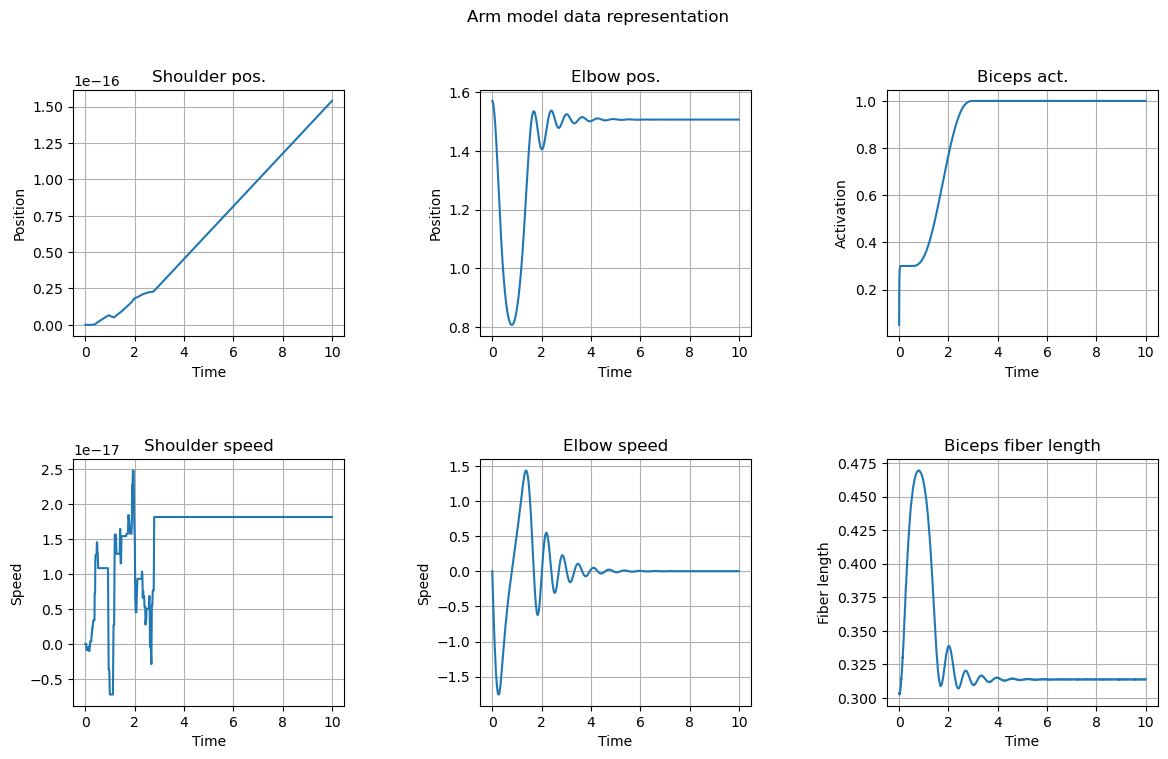

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create six subplots, with 2 rows and 3 columns.
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Arm model data representation')

# Plot shoulder position and speed in column 1.
axs[0, 0].plot(times, shoulder_pos.to_numpy())
axs[0, 0].set_title('Shoulder pos.')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Position')
axs[0, 0].grid()
axs[1, 0].plot(times, shoulder_speed.to_numpy())
axs[1, 0].set_title('Shoulder speed')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Speed')
axs[1, 0].grid()

# Plot elbow position and speed in column 2.
axs[0, 1].plot(times, elbow_pos.to_numpy())
axs[0, 1].set_title('Elbow pos.')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Position')
axs[0, 1].grid()
axs[1, 1].plot(times, elbow_speed.to_numpy())
axs[1, 1].set_title('Elbow speed')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Speed')
axs[1, 1].grid()

# Plot biceps activation and length in column 3.
axs[0, 2].plot(times, biceps_activation.to_numpy())
axs[0, 2].set_title('Biceps act.')
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Activation')
axs[0, 2].grid()
axs[1, 2].plot(times, biceps_fiber_length.to_numpy())
axs[1, 2].set_title('Biceps fiber length')
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Fiber length')
axs[1, 2].grid()

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

## 2.5. Conclusion

In this tutorial you have created a simple arm model defined by two bones (bodies), two joints, and a muscle (actuator). Then, you have simulated the model and plotted the calculated values.

To create more complex models graphically and visualize them, check [OpenSim Creator](https://opensimcreator.com/). OpenSim Creator is freely available, open-source software that enables people to visually build, edit, and simulate OpenSim models.

## 2.6. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
> 
> **OpenSim Creator Website:** https://opensimcreator.com/
> 
> **SimTK Website:** https://simtk.org/projects/opensim
> 
> **Biomechanics of Movement Course Videos:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA

##2.7 Acknowledgments

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[4]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 2.8. References




> [1] Delp, S. L., Anderson, F. C., Arnold, A. S., Loan, P., Habib, A., John, C. T., Guendelman, E., & Thelen, D. G. (2007). **OpenSim: open-source software to create and analyze dynamic simulations of movement.** *IEEE Transactions on Bio-Medical Engineering*, 54(11), 1940–1950. https://doi.org/10.1109/TBME.2007.901024
>
> [2] Uchida, T. K., Delp, S. L., & Delp, D. (2021). **Biomechanics of movement: The science of sports, robotics, and rehabilitation.** *MIT Press*. https://mitpress.mit.edu/9780262044202/biomechanics-of-movement/
>
> [3] Millard, M., Uchida, T., Seth, A., & Delp, S. L. (2013). **Flexing computational muscle: Modeling and simulation of musculotendon dynamics.** *Journal of Biomechanical Engineering*, 135(2). https://doi.org/10.1115/1.4023390
>
> [4] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607